See `Dataset for Metric Alignment` on Notes 

## Set LLM to use

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/shahules/ragas/alingment-exp/")


In [3]:
from langchain_openai.chat_models import ChatOpenAI
from ragas.llms import LangchainLLMWrapper

llm_4o = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
llm_4o_mini = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

/opt/homebrew/Caskroom/miniforge/base/envs/ragas/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_aws import ChatBedrockConverse
from langchain_aws import BedrockEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

config = {
    "credentials_profile_name": "default",  # E.g "default"
    "region_name": "us-east-1",  # E.g. "us-east-1"
    "llm": "anthropic.claude-3-haiku-20240307-v1:0",  # E.g "anthropic.claude-3-5-sonnet-20240620-v1:0"
}

bedrock_llm = ChatBedrockConverse(
    credentials_profile_name=config["credentials_profile_name"],
    region_name=config["region_name"],
    base_url=f"https://bedrock-runtime.{config['region_name']}.amazonaws.com",
    model=config["llm"],
)

bedrock_llm = LangchainLLMWrapper(bedrock_llm)

## Metric - Factual correctness


In [17]:
from scripts.prompts import *

In [18]:
FORMAT_TRANSFORMATIONS = [
    "Convert between narrative paragraphs and bullet points or vice versa.",
    "Organize the content using headings and subheadings.",
    "Change the order of information from chronological to thematic organization, or vice versa."
]
STYLE_TRANSFORMATIONS = [
    "Modify the answer by adding hedging language to make some statements less certain",
    "Rewrite the answer using passive voice to introduce subtle ambiguity",
    "Introduce ambiguity into the answer by making some statements less precise",
    "Present the information in a different format (e.g., from bullet points to paragraphs or vice versa)."
]


ERROR_TRANSFORMATIONS = [
    "Subtly introduce one minor claim along with an existing sentence",
    "Subtly introduce single minor inconsistency in the cause-and-effect relationship.",
    "Subtly add or remove single negation to change the meaning of a statement.",
    "Introduce a subtle factual error"
]

In [39]:
# Define your percentages for each answer type
ANSWER_LENGTH_DICT = {
    "med (50+ words)": 1.0,    # 40%
}


In [40]:
!pwd

/Users/shahules/ragas/alingment-exp


In [72]:
def load_terms():
    # Path to the file
    file_path = './datasets/Extended_Scientific_Theories_List.txt'
    
    # Reading the file into a list
    with open(file_path, 'r') as file:
        terms_list = [line.strip() for line in file.readlines()]

    return terms_list

In [73]:
len(load_terms())

156

In [74]:
import numpy as np
from tqdm import tqdm

In [75]:

samples = []
for term in tqdm(load_terms()[:]):
    try:
        sample = {}    
        answer_length = np.random.choice(list(ANSWER_LENGTH_DICT.keys()),1,p=list(ANSWER_LENGTH_DICT.values()))[0]
        
        prompt = QuestionAnswerPrompt()
        prompt_input = CreateQuestion(term=term, answer_length=answer_length)
        output = await prompt.generate(data=prompt_input, llm=llm_4o)
        sample.update(
            {
                "user_input":output.question,
                "reference":output.answer,
                "term":term,
            }
        )
    
        # style = np.random.choice(FORMAT_TRANSFORMATIONS,1)[0]
        # format = np.random.choice(STYLE_TRANSFORMATIONS,1)[0]
        # action = f"Format Transformation:{format}\nStyle Transformation:{style}"
    
    
        
        # prompt = ResponseTransformationPrompt()
        # prompt_input = ModifyAnswer(original_answer=output.answer, action=action)
        # output = await prompt.generate(data=prompt_input, llm=llm_4o)
        # sample.update({
        #     "response1":output.new_answer,
        # })
        
        # error = np.random.choice(ERROR_TRANSFORMATIONS,1)[0]
        # prompt = ErrorInductionPrompt()
        # prompt_input = ModifyAnswer(original_answer=output.new_answer,action=error)
        # output = await prompt.generate(data=prompt_input, llm=llm_4o)
    
        prompt = ELI5Prompt()
        prompt_input = RewriteReference(question=output.question,reference_answer=output.answer)
        output = await prompt.generate(data=prompt_input, llm=llm_4o)
        
        sample.update({
            "response":output.rewritten_answer,
        })
        
        samples.append(sample)
    except Exception as e:
        print(e)
    
        

100%|███████████████████████████| 156/156 [13:33<00:00,  5.21s/it]


In [76]:
from datasets import Dataset
dataset = Dataset.from_list(samples)


In [77]:
dataset.to_json("datasets/dataset_eli5.json")

Creating json from Arrow format: 100%|█| 1/1 [00:00<00:00, 240.55b


206075

In [78]:
dataset[-1]

{'user_input': 'What is the Theory of Bose-Einstein Condensation and how does it explain the behavior of particles at extremely low temperatures?',
 'reference': 'The Theory of Bose-Einstein Condensation describes a state of matter that occurs when particles known as bosons are cooled to temperatures very close to absolute zero. At these extremely low temperatures, a large fraction of the bosons occupy the lowest quantum state, resulting in a macroscopic quantum phenomenon. This state of matter was predicted by Albert Einstein and Satyendra Nath Bose in the early 20th century. In this state, the particles lose their individual identities and behave as a single quantum entity, exhibiting properties such as superfluidity and coherence. This theory has significant implications in quantum mechanics and has been observed in laboratory conditions with certain types of atoms, such as rubidium and sodium.',
 'term': 'Theory of Bose-Einstein Condensation',
 'response': 'The Theory of Bose-Einst

## Synthesize some negative points
ie introduce factual inaccuracies. 

In [79]:
from scripts.prompts import RewritePromptWithError, Response
from datasets import Dataset
from tqdm import tqdm


In [80]:
prompt = RewritePromptWithError()


In [81]:
dataset =  Dataset.from_json("datasets/dataset_eli5.json")
prompt = RewritePromptWithError()
samples = []
for row in tqdm(dataset):
    response = await prompt.generate(data=Response(response=row['response']),llm=llm_4o_mini)
    samples.append(response.model_dump())


    
dataset_error = Dataset.from_list(samples)
# dataset.to_json("datasets/dataset_v4_errored.json")
    

Generating train split: 156 examples [00:00, 15288.36 examples/s]
100%|███████████████████████████| 156/156 [08:40<00:00,  3.34s/it]


In [82]:
from datasets import concatenate_datasets
dataset = concatenate_datasets([dataset,dataset_error],axis=1)
dataset.to_json("datasets/dataset_eli5.json")

Creating json from Arrow format: 100%|█| 1/1 [00:00<00:00, 299.32b


314937

In [136]:
def prepare_eval_dataset(path,num_samples, postive_clas=0.6, seed=42):

    def get_dataset(dataset,postive_clas):

        num_samples = len(dataset)
        num = int(num_samples*postive_clas)
        indices = np.arange(0,len(dataset))
        positive_sample_indices = np.random.choice(indices, num,replace=False).tolist()
        negative_sample_indices = [i for i in range(len(dataset)) if i not in positive_sample_indices]
        samples = []
        for i,row in enumerate(dataset):
            dic = {
                    "user_input":row["user_input"],
                    "reference": row["reference"],
                                    
                }
            if i in positive_sample_indices:
                dic.update(
                    {
                        "response": row["response"],
                        "target": 1
                    }
                )
            else:
                 dic.update(
                    {
                        "response": row["errored_response"],
                        "target": 0
                    }
                )
            samples.append(dic)
        return Dataset.from_list(samples)

    
    samples = []
    np.random.seed(seed)
    dataset = Dataset.from_json(path)
    dataset = dataset.shuffle(seed=seed)
    train_dataset = dataset.select(range(0,100))
    test_dataset = dataset.select(range(100, len(dataset)))
    print(test_dataset)
    train_dataset = get_dataset(train_dataset,postive_clas)
    test_dataset = get_dataset(test_dataset,postive_clas)
    return train_dataset,test_dataset

    
                                  
    
    
            
            
    

In [137]:
train,test = prepare_eval_dataset("datasets/dataset_eli5.json",100)

Dataset({
    features: ['user_input', 'reference', 'term', 'response', 'errored_response', 'error_description'],
    num_rows: 56
})


In [138]:
len(test)

56

In [128]:
sum(test['target'])

93

In [139]:

train.push_to_hub("explodinggradients/alingment_eli5",split="test")
test.push_to_hub("explodinggradients/alingment_eli5",split="train")

Uploading the dataset shards:   0%|         | 0/1 [00:00<?, ?it/s]
Creating parquet from Arrow format: 100%|█| 1/1 [00:00<00:00, 171.
Uploading the dataset shards:   0%|         | 0/1 [00:00<?, ?it/s]
Creating parquet from Arrow format: 100%|█| 1/1 [00:00<00:00, 260.
Uploading the dataset shards: 100%|█| 1/1 [00:02<00:00,  2.26s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/explodinggradients/alingment_eli5/commit/f8ca2a67ba5550f3880e699ac86b7006b8c0e71e', commit_message='Upload dataset', commit_description='', oid='f8ca2a67ba5550f3880e699ac86b7006b8c0e71e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/explodinggradients/alingment_eli5', endpoint='https://huggingface.co', repo_type='dataset', repo_id='explodinggradients/alingment_eli5'), pr_revision=None, pr_num=None)

## MIX BOTH

In [21]:
from datasets import concatenate_datasets

In [22]:
dataset = concatenate_datasets([dataset,dataset_error],axis=1)
dataset.to_json("datasets/dataset_eli5.json")


Creating json from Arrow format: 100%|███████████████████| 1/1 [00:00<00:00, 189.54ba/s]


243251

In [29]:
samples[2]

{'errored_response': "# The Birth of Democracy in Athens: A Revolutionary Shift\nThe emergence of democracy in Athens during the 6th century BCE was a groundbreaking development that transformed the political landscape of ancient Greece. Here's how this revolutionary system reshaped governance:\n\n## A Radical Departure from Tradition\n- **From Monarchies to Democracy:** Before democracy, monarchies and oligarchies were the norm, where power was concentrated in the hands of a few. The Athenian model introduced a stark contrast by empowering ordinary citizens to have a direct say in governance.\n- **Pioneering Leaders:** Visionaries like Cleisthenes spearheaded this transformation, dismantling the old political structures and paving the way for greater citizen involvement. His reforms were akin to a political revolution, shifting power from the elite to the people.\n\n## Key Democratic Institutions\n- **The Assembly:** This was the beating heart of Athenian democracy, where citizens gat

In [13]:
# dataset.push_to_hub("explodinggradients/physics_metrics_alignment")

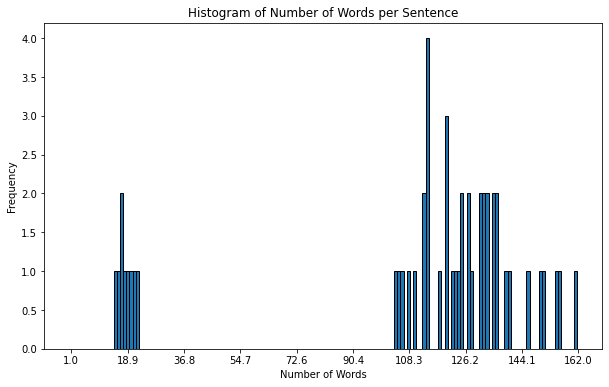

In [14]:
import matplotlib.pyplot as plt

def plot_word_histogram(input_list):
    # Count the number of words in each string
    word_counts = [len(sentence.split()) for sentence in input_list]
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=range(1, max(word_counts) + 2), edgecolor='black', align='left')
    
    plt.title('Histogram of Number of Words per Sentence')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    max_word_count = max(word_counts)
    bins = np.linspace(1, max_word_count + 1, num=10)  # Adjust the number of bins
    plt.xticks(bins)
    plt.show()

plot_word_histogram(dataset['reference'])

In [15]:
# from collections import Counter
# targets = Counter(dataset['answer_style'])
# plt.figure(figsize=(10, 6))
# plt.bar(targets.keys(), targets.values(), color='lightblue')
# plt.show()

## Evaluation

In [16]:
import os
os.environ["LANGCHAIN_PROJECT"]= "Alignment"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [17]:
from ragas.metrics import FactualCorrectness
from ragas import EvaluationDataset
from datasets import load_dataset, Dataset
dataset = Dataset.from_json("datasets/dataset_v3.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
dataset[1]

{'user_input': 'How did the discovery of fire impact early human societies and their development?',
 'reference': 'The discovery of fire was a pivotal moment in human history, profoundly impacting early human societies and their development. Fire provided warmth, protection, and a means to cook food, which led to significant dietary changes and improved nutrition. This allowed early humans to thrive in various environments and expand their territories. The ability to cook food also made it easier to digest and safer to eat, reducing the risk of disease. Fire enabled the development of new tools and technologies, as it was used to harden wooden tools and later to work with metals. Socially, fire became a focal point for gatherings, fostering communication, cooperation, and the sharing of knowledge. It also played a crucial role in cultural and ritualistic practices, influencing the social structures and belief systems of early human communities. Overall, the mastery of fire was a cataly

## 
Evaluating with different settings

In [19]:
from ragas import evaluate
import numpy as np

subsample = dataset
ragas_dataset = EvaluationDataset.from_hf_dataset(subsample)


### Case 1: Ragas with default prompt + (No demo)

In [20]:
ragas_output = evaluate(ragas_dataset[:], metrics=[FactualCorrectness(with_examples=False)],raise_exceptions=True)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
ragas_output.to_pandas()

,user_input,response,reference,factual_correctness
0,How did the invention of the wheel impact anci...,# The Revolutionary Impact of the Wheel on Anc...,The invention of the wheel was a pivotal momen...,0.82
1,How did the discovery of fire impact early hum...,# The Transformative Power of Fire in Early Hu...,The discovery of fire was a pivotal moment in ...,0.99
2,What were the major impacts of the Agricultura...,# The Transformative Impacts of the Agricultur...,"The Agricultural Revolution, which began aroun...",1.00
3,What were the key events and consequences of t...,# The Fall of Constantinople: A Turning Point ...,"The Fall of Constantinople occurred on May 29,...",1.00
4,How did the birth of democracy in Athens shape...,# The Birth of Democracy in Athens: A Revoluti...,"The birth of democracy in Athens, around the 5...",1.00
5,What were the significant impacts of the signi...,# The Magna Carta: A Cornerstone of Constituti...,The signing of the Magna Carta in 1215 had pro...,1.00
6,What were the causes and impacts of The Black ...,# The Black Death: Causes and Impacts on Medie...,"The Black Death, which swept through Europe in...",1.00
7,What were the significant impacts of Columbus'...,# The Transformative Impact of Columbus' 1492 ...,Columbus' voyage to the Americas in 1492 had p...,0.98
8,What was the Protestant Reformation?,# The Protestant Reformation: A Revolution in ...,The Protestant Reformation was a 16th-century ...,0.98
9,What were the major impacts of the Industrial ...,# The Transformative Impacts of the Industrial...,"The Industrial Revolution, which began in the ...",0.95


In [27]:
pred = np.nan_to_num(ragas_output.to_pandas()['factual_correctness'].values).tolist()
real = [1]* len(pred)

In [28]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred,real)*100

1.9400000000000015

In [29]:
ragas_output.to_pandas().to_csv("results/default_prompt_no_demo.csv",index=False)

## Case 2 : Ragas with default prompt + Random 3 demo

In [31]:
scorer = FactualCorrectness(with_examples=True)

In [32]:
ragas_output = evaluate(ragas_dataset, metrics=[scorer])

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [34]:

pred = np.nan_to_num(ragas_output.to_pandas()['factual_correctness'].values).tolist()
real = [1]* len(pred)

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred,real)*100

2.160000000000001

In [36]:
ragas_output.to_pandas().to_csv("results/default_prompt_demo.csv",index=False)

## Analysis